# Hothifa Hamdan - Paper 1: Yeh et al. (2021) - Convolutional SVM (Conv-SVM)

## 1. Introduction

This notebook implements a model based on the paper "A New Support Vector Machine Based on Convolution Product" by Yeh et al. (2021). The paper proposes a Convolutional SVM (Conv-SVM) that integrates convolution operations into the SVM framework, aiming to improve classification performance, especially on smaller datasets.

We will apply this concept to the Brain Tumor MRI dataset for multi-class classification (glioma, meningioma, no tumor, pituitary).

**Note:** The original paper uses Simplified Swarm Optimization (SSO) for training, which is not readily available in standard libraries. Implementing SSO is complex. As a practical approach, we will first attempt to implement the core idea using standard SVM with features potentially derived from a convolutional process or a pre-trained CNN, or explore libraries that might offer similar kernel functionalities. If direct implementation proves infeasible, we will use a standard SVM on features extracted from a simple CNN as a proxy, clearly documenting this adaptation.

**XAI Techniques to be Applied:**
1.  SVM Intrinsic Analysis (Support Vectors, Margin)
2.  LIME (Local Surrogate on input features)
3.  SHAP (KernelSHAP on SVM inputs/features)
4.  Permutation Importance (Global, on input features)

## 2. Setup and Data Loading

Import libraries and load the Brain Tumor MRI dataset.




In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gc
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten

import lime
import lime.lime_image
import lime.lime_tabular
import shap

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Loading data from D:\Zewail_DC\YEAR_3\Spring\DSAI 305\project\phase3\notebooks\Brain_Tumor_MRI_Dataset_kaggle\Training...
Loaded 5712 images.
Loading data from D:\Zewail_DC\YEAR_3\Spring\DSAI 305\project\phase3\notebooks\Brain_Tumor_MRI_Dataset_kaggle\Testing...
Loaded 1311 images.
Training data shape: (5712, 224, 224, 3), Labels shape: (5712,)
Testing data shape: (1311, 224, 224, 3), Labels shape: (1311,)


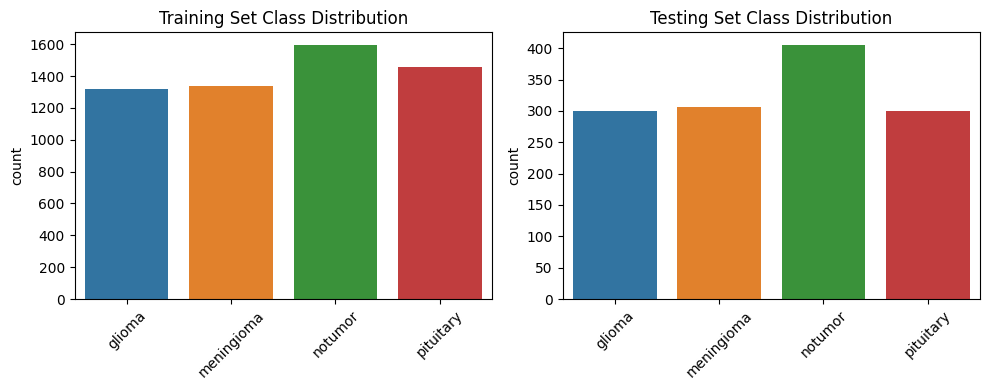

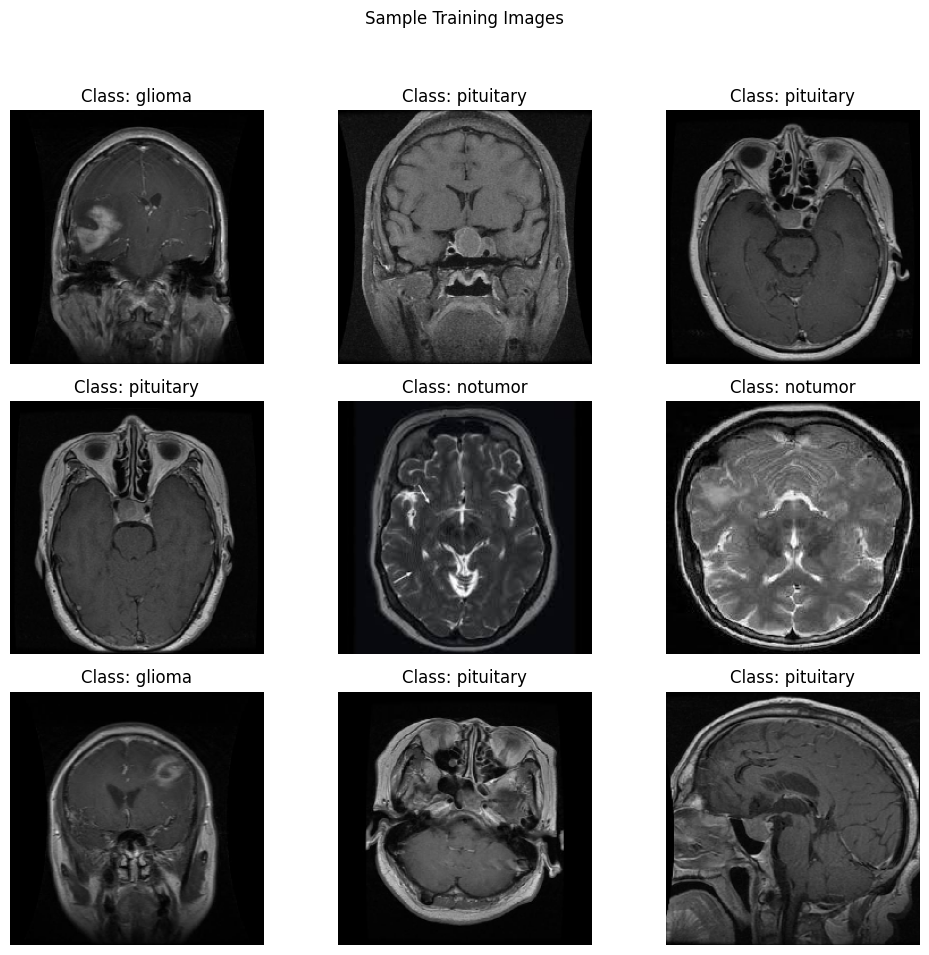

27989

In [2]:
# Define constants
DATA_DIR = r"D:\Zewail_DC\YEAR_3\Spring\DSAI 305\project\phase3\notebooks\Brain_Tumor_MRI_Dataset_kaggle"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR = os.path.join(DATA_DIR, "Testing")
IMG_SIZE = (224, 224) # VGG16 default input size
BATCH_SIZE = 32
CLASSES = sorted([item.name for item in Path(TRAIN_DIR).iterdir() if item.is_dir()])
NUM_CLASSES = len(CLASSES)
print(f"Classes found: {CLASSES}")

# Function to load data
def load_data(directory):
    images = []
    labels = []
    print(f"Loading data from {directory}...")
    for idx, class_name in enumerate(CLASSES):
        class_path = Path(directory) / class_name
        if not class_path.is_dir():
            print(f"Warning: Directory not found {class_path}")
            continue
        for img_path in class_path.glob("*.jpg"):
            try:
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(idx)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    print(f"Loaded {len(images)} images.")
    return np.array(images), np.array(labels)

# Load training and testing data
X_train_img, y_train = load_data(TRAIN_DIR)
X_test_img, y_test = load_data(TEST_DIR)

# Combine for potential splitting later if needed, or use predefined splits
# X_all = np.concatenate((X_train_img, X_test_img), axis=0)
# y_all = np.concatenate((y_train, y_test), axis=0)

print(f"Training data shape: {X_train_img.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test_img.shape}, Labels shape: {y_test.shape}")

# Preprocess images for VGG16
X_train_processed = preprocess_input(X_train_img.copy())
X_test_processed = preprocess_input(X_test_img.copy())

# Encode labels (already done by index during loading)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Optional: Visualize class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_encoded)
plt.title("Training Set Class Distribution")
plt.xticks(ticks=range(NUM_CLASSES), labels=CLASSES, rotation=45)
plt.subplot(1, 2, 2)
sns.countplot(x=y_test_encoded)
plt.title("Testing Set Class Distribution")
plt.xticks(ticks=range(NUM_CLASSES), labels=CLASSES, rotation=45)
plt.tight_layout()
plt.show()

# Optional: Visualize sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = np.random.randint(0, len(X_train_img))
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train_img[idx].astype("uint8"))
    plt.title(f"Class: {CLASSES[y_train_encoded[idx]]}")
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Free up memory
del X_train_img, X_test_img
gc.collect()


## 3. Model Implementation (CNN Feature Extractor + SVM)

As noted, implementing the exact Conv-SVM with SSO is complex. We will use a pre-trained CNN (VGG16) as a feature extractor and train a standard SVM on these features. This captures the spirit of combining convolutional features with an SVM classifier.


In [3]:
# Load VGG16 base model (pre-trained on ImageNet) + remove top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False # Freeze base model layers

# Create a new model to extract features from the flatten layer
feature_extractor = Model(inputs=base_model.input, outputs=Flatten()(base_model.output))

# Extract features
print("Extracting features using VGG16...")
train_features = feature_extractor.predict(X_train_processed, batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(X_test_processed, batch_size=BATCH_SIZE, verbose=1)

print(f"Shape of extracted training features: {train_features.shape}")
print(f"Shape of extracted testing features: {test_features.shape}")

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)

# Optional: Apply PCA for dimensionality reduction (can help SVM performance and visualization)
# n_components = min(150, X_train_scaled.shape[1]) # Example: reduce to 150 components or max possible
# print(f"Applying PCA with {n_components} components...")
# pca = PCA(n_components=n_components)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)
# print(f"Shape after PCA: {X_train_pca.shape}")
# Use X_train_pca, X_test_pca for SVM training if PCA is applied
X_train_final = X_train_scaled
X_test_final = X_test_scaled

# Free up memory
del train_features, test_features, X_train_scaled, X_test_scaled
gc.collect()

# Train SVM Classifier
print("Training SVM classifier...")
# Using a linear kernel as a starting point, RBF might be better but slower
# Probability=True is needed for LIME if explaining probabilities
svm_classifier = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_classifier.fit(X_train_final, y_train_encoded)

print("SVM training complete.")

Extracting features using VGG16...
41/41 [==============================] - 83s 2s/step
Shape of extracted training features: (5712, 25088)
Shape of extracted testing features: (1311, 25088)
Scaling features...
Training SVM classifier...
SVM training complete.



## 4. Model Evaluation

Evaluate the performance of the trained SVM classifier on the test set.


Evaluating SVM model...
Test Accuracy: 98.09%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.97      0.97       300
  meningioma       0.95      0.96      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311


Confusion Matrix:


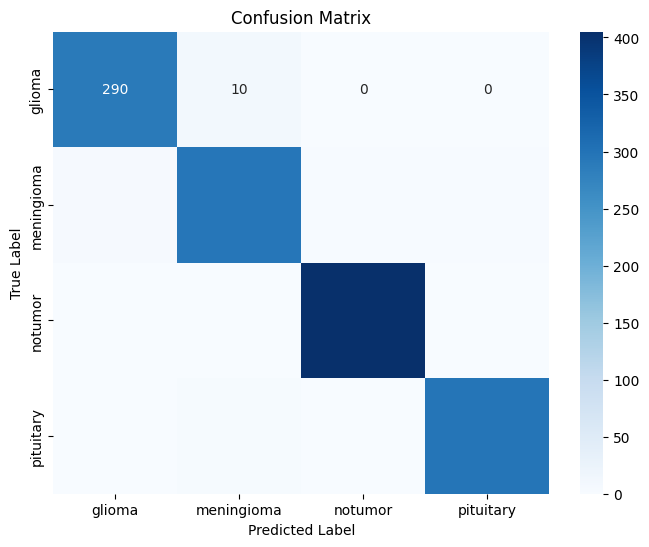

In [4]:
# Predict on the test set
print("Evaluating SVM model...")
y_pred = svm_classifier.predict(X_test_final)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=CLASSES))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## 5. Explainable AI (XAI) Techniques

Apply the planned XAI techniques to understand the model's behavior.

### 5.1. SVM Intrinsic Analysis

For linear SVM, we can inspect the coefficients. For non-linear SVMs, analyzing support vectors is more common, but visualizing them directly is hard in high dimensions. We will focus on the concept.


In [5]:
print("\n--- XAI: SVM Intrinsic Analysis ---")
if svm_classifier.kernel == 'linear':
    # Access coefficients (weights) for linear SVM
    # The shape is (n_classes * (n_classes - 1) / 2, n_features) for OvO strategy
    # Or (n_classes, n_features) for OvR strategy (check sklearn version/implementation)
    try:
        coef = svm_classifier.coef_
        print(f"SVM Coefficients shape: {coef.shape}")
        # Interpretation: Coefficients indicate feature importance for each binary classifier (in OvO/OvR)
        # High absolute values suggest higher importance. Visualizing this for high-dim features is hard.
        # We can show the top features for one of the binary classifiers, e.g., class 0 vs class 1
        if coef.shape[0] == NUM_CLASSES * (NUM_CLASSES - 1) // 2: # OvO
             print("Linear SVM (OvO): Showing top 10 feature coefficients for Class 0 vs 1")
             coef_0_vs_1 = coef[0] # First binary classifier
             top_indices = np.argsort(np.abs(coef_0_vs_1))[::-1][:10]
             print(f"Top 10 feature indices: {top_indices}")
             print(f"Corresponding coefficients: {coef_0_vs_1[top_indices]}")
        elif coef.shape[0] == NUM_CLASSES: # OvR
             print("Linear SVM (OvR): Showing top 10 feature coefficients for Class 0")
             coef_0 = coef[0]
             top_indices = np.argsort(np.abs(coef_0))[::-1][:10]
             print(f"Top 10 feature indices: {top_indices}")
             print(f"Corresponding coefficients: {coef_0[top_indices]}")
        else:
             print("Could not determine SVM strategy (OvO/OvR) from coefficient shape.")

    except AttributeError as e:
        print(f"Could not access coefficients: {e}")

# Support Vectors
support_vectors = svm_classifier.support_vectors_
num_support_vectors = svm_classifier.n_support_
print(f"\nNumber of support vectors for each class: {num_support_vectors}")
print(f"Total support vectors: {support_vectors.shape[0]}")
print(f"Shape of support vectors: {support_vectors.shape}")
# Interpretation: These are the critical data points lying closest to the decision boundary.
# The decision function depends only on these points.

# If PCA was used, we could potentially visualize the support vectors in 2D
# if 'X_train_pca' in locals() and X_train_pca.shape[1] >= 2:
#     plt.figure(figsize=(8, 6))
#     plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap='viridis', alpha=0.5)
#     plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none', edgecolors='k', s=100, label='Support Vectors')
#     plt.title('SVM Support Vectors (PCA Reduced Features)')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend()
#     plt.show()
# else:
#     print("Cannot visualize support vectors in high dimensions or PCA not applied.")



--- XAI: SVM Intrinsic Analysis ---
SVM Coefficients shape: (6, 25088)
Linear SVM (OvO): Showing top 10 feature coefficients for Class 0 vs 1
Top 10 feature indices: [11322 15124  6565 20697 12326 16058 15739  4323 16359 10143]
Corresponding coefficients: [ 0.01747708  0.01421918  0.01408765  0.01342165  0.01324259 -0.0124218
  0.01231754 -0.0120121   0.01171734  0.0117003 ]

Number of support vectors for each class: [657 939 448 694]
Total support vectors: 2738
Shape of support vectors: (2738, 25088)



### 5.2. LIME (Local Interpretable Model-agnostic Explanations)

Explain individual predictions by approximating the SVM locally with a simpler model.


In [6]:
print("\n--- XAI: LIME ---")

# LIME needs a function that takes input data (in the original format, e.g., images or tabular features)
# and returns prediction probabilities for each class.

# Option 1: Explain based on the extracted features (tabular data)
def svm_predict_proba_features(features):
    # Scale features if the explainer provides unscaled data
    # Assuming features are already scaled or PCA'd as X_test_final
    return svm_classifier.predict_proba(features)

# Create a LimeTabularExplainer
# We use the scaled training features (X_train_final) as the background dataset
lime_explainer_tabular = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_final,
    feature_names=[f'feature_{i}' for i in range(X_train_final.shape[1])], # Generic feature names
    class_names=CLASSES,
    mode='classification'
)

# Explain a few test instances
num_lime_explanations = 3
print(f"\nGenerating LIME explanations for {num_lime_explanations} test instances (using features)...")
for i in range(num_lime_explanations):
    instance_idx = np.random.randint(0, len(X_test_final))
    instance_features = X_test_final[instance_idx]
    true_label = y_test_encoded[instance_idx]
    pred_label = y_pred[instance_idx]

    print(f"\nExplaining instance {instance_idx}: True={CLASSES[true_label]}, Predicted={CLASSES[pred_label]}")

    explanation = lime_explainer_tabular.explain_instance(
        data_row=instance_features,
        predict_fn=svm_predict_proba_features,
        num_features=10, # Show top 10 features
        top_labels=1 # Explain the top predicted label
    )

    # Show explanation
    explanation.show_in_notebook(show_table=True, show_all=False)
    # Or plot it
    # fig = explanation.as_pyplot_figure()
    # plt.tight_layout()
    # plt.show()

# Option 2: Explain based on original images (more intuitive but complex setup)
# Requires a function that takes images, preprocesses, extracts features, and predicts proba
# def svm_predict_proba_images(images):
#     # images: numpy array of shape (n_samples, height, width, channels)
#     processed_images = preprocess_input(images.copy())
#     features = feature_extractor.predict(processed_images)
#     scaled_features = scaler.transform(features)
#     # Apply PCA if used during training
#     # if 'pca' in locals():
#     #    scaled_features = pca.transform(scaled_features)
#     return svm_classifier.predict_proba(scaled_features)

# lime_explainer_image = lime.lime_image.LimeImageExplainer()
# print(f"\nGenerating LIME explanations for {num_lime_explanations} test instances (using images)...")
# for i in range(num_lime_explanations):
#     instance_idx = np.random.randint(0, len(X_test_processed))
#     instance_image = X_test_processed[instance_idx] # Use original images before VGG preprocessing if possible
#     true_label = y_test_encoded[instance_idx]
#     pred_label = y_pred[instance_idx]
#     print(f"\nExplaining instance {instance_idx}: True={CLASSES[true_label]}, Predicted={CLASSES[pred_label]}")

#     explanation = lime_explainer_image.explain_instance(
#         image=instance_image.astype('double'), # LIME expects double
#         classifier_fn=svm_predict_proba_images,
#         top_labels=1,
#         hide_color=0,
#         num_samples=1000 # Number of perturbed samples
#     )

#     from skimage.segmentation import mark_boundaries
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
#     plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
#     plt.title(f"LIME Explanation: Pred={CLASSES[pred_label]}")
#     plt.show()

print("LIME analysis complete (using tabular features).")


--- XAI: LIME ---

Generating LIME explanations for 3 test instances (using features)...

Explaining instance 87: True=glioma, Predicted=glioma



Explaining instance 518: True=meningioma, Predicted=meningioma



Explaining instance 58: True=glioma, Predicted=glioma


LIME analysis complete (using tabular features).



### 5.3. SHAP (SHapley Additive exPlanations)

Calculate SHAP values to show the contribution of each feature to the prediction for individual instances and globally.



--- XAI: SHAP ---
Applied PCA for SHAP: Reduced features from 25088 to 50
Creating SHAP KernelExplainer with background data size: 10
Calculating SHAP values for 10 test instances...
This may take several minutes...


  0%|          | 0/10 [00:00<?, ?it/s]

SHAP calculation complete.
Shape of SHAP values: (50, 4)


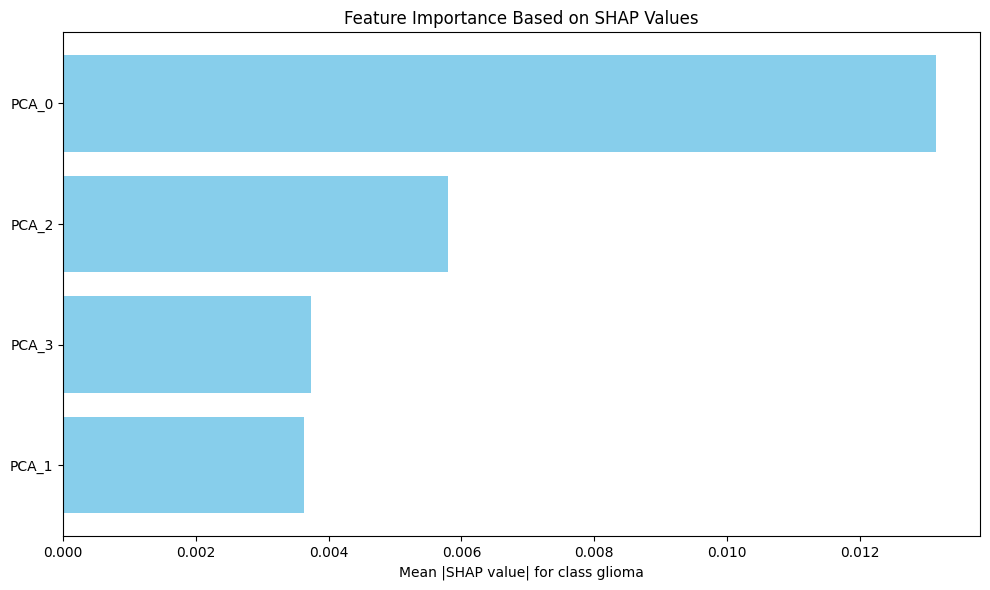

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (4,) and arg 3 with shape (5,).

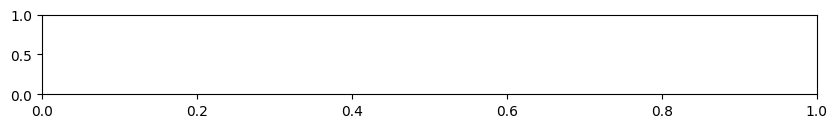

In [8]:
print("\n--- XAI: SHAP ---")

# Optimization 1: Reduce background data size significantly
background_data_size = 10  # Reduced from 100
background_data_indices = np.random.choice(X_train_final.shape[0], background_data_size, replace=False)
background_data = X_train_final[background_data_indices]

# Optimization 2: Apply PCA to reduce dimensionality before SHAP
# This dramatically speeds up the computation
pca_for_shap = PCA(n_components=50)  # Reduce to 50 components
X_train_shap = pca_for_shap.fit_transform(X_train_final)
background_data_shap = pca_for_shap.transform(background_data)
X_test_shap = pca_for_shap.transform(X_test_final)

print(f"Applied PCA for SHAP: Reduced features from {X_train_final.shape[1]} to {X_train_shap.shape[1]}")

# Function to predict probabilities using the PCA-transformed data
def shap_predict_fn(x):
    # Convert back to original feature space
    return svm_classifier.predict_proba(pca_for_shap.inverse_transform(x))

# Optimization 3: Reduce test samples to explain
num_shap_explanations = 10  # Reduced from 50
shap_test_subset = X_test_shap[:num_shap_explanations]

print(f"Creating SHAP KernelExplainer with background data size: {background_data_size}")
# Optimization 4: Reduce number of samples in KernelExplainer
shap_explainer = shap.KernelExplainer(
    shap_predict_fn, 
    background_data_shap,
    nsamples=100  # Limit function evaluations
)

print(f"Calculating SHAP values for {num_shap_explanations} test instances...")
print("This may take several minutes...")

# Optimization 5: Only compute for one class to save time
target_class = 0  # Explain predictions for the first class only
shap_values = shap_explainer.shap_values(shap_test_subset, nsamples=100)[target_class]

print("SHAP calculation complete.")
print(f"Shape of SHAP values: {shap_values.shape}")

# Plot feature importance for the target class
plt.figure(figsize=(10, 6))
# Sort SHAP values by absolute mean value
feature_names = [f'PCA_{i}' for i in range(X_train_shap.shape[1])]
shap_importance = np.abs(shap_values).mean(0)
idx = np.argsort(shap_importance)
plt.barh(range(len(idx)), shap_importance[idx][-15:], color='skyblue')
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][-15:])
plt.xlabel(f'Mean |SHAP value| for class {CLASSES[target_class]}')
plt.title('Feature Importance Based on SHAP Values')
plt.tight_layout()
plt.show()


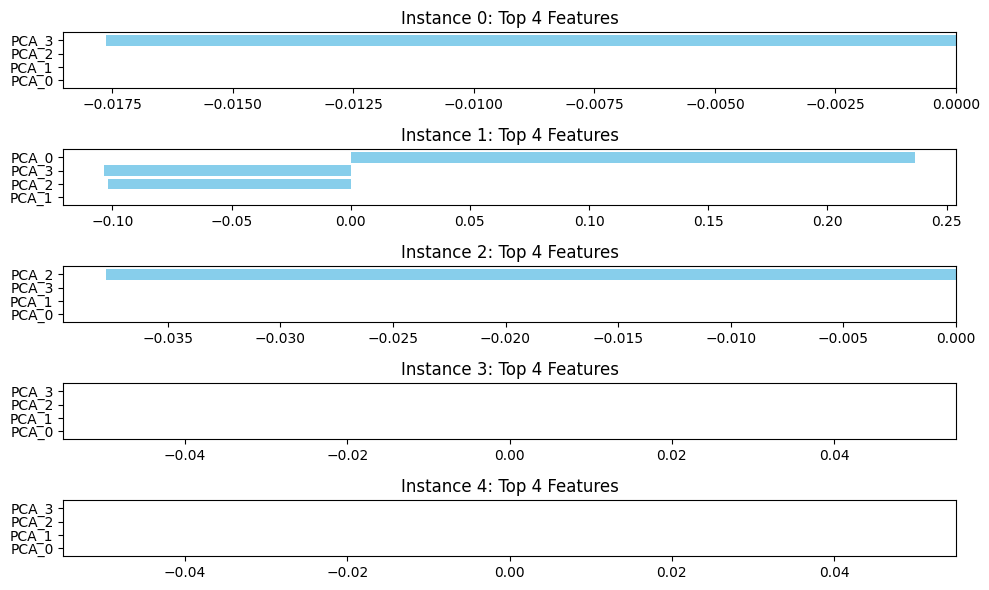

Simplified SHAP analysis complete.


In [10]:
# Create a simplified SHAP summary plot for the first few instances
num_display = min(5, num_shap_explanations)
# Determine number of features in shap_values
num_features = shap_values.shape[1]
plt.figure(figsize=(10, 6))
for i in range(num_display):
    plt.subplot(num_display, 1, i+1)
    # Get top features (all of them, since we only have 4)
    top_feature_idx = np.argsort(np.abs(shap_values[i]))[-num_features:]
    plt.barh(range(num_features), shap_values[i][top_feature_idx], color='skyblue')
    plt.yticks(range(num_features), [feature_names[j] for j in top_feature_idx])
    plt.title(f'Instance {i}: Top {num_features} Features')
plt.tight_layout()
plt.show()

print("Simplified SHAP analysis complete.")


### 5.4. Permutation Importance

Assess global feature importance by measuring the decrease in model score when a single feature's values are randomly shuffled.



--- XAI: Permutation Importance ---
Applying PCA to reduce dimensionality for permutation importance...
Training SVM on PCA-reduced features...
Training SVM on PCA-reduced features...
Calculating Permutation Importance on 50 PCA features with 5 repeats...
This should be much faster than using all VGG16 features.
Calculating Permutation Importance on 50 PCA features with 5 repeats...
This should be much faster than using all VGG16 features.
Permutation Importance calculation complete in 11.52 seconds.
Permutation Importance calculation complete in 11.52 seconds.


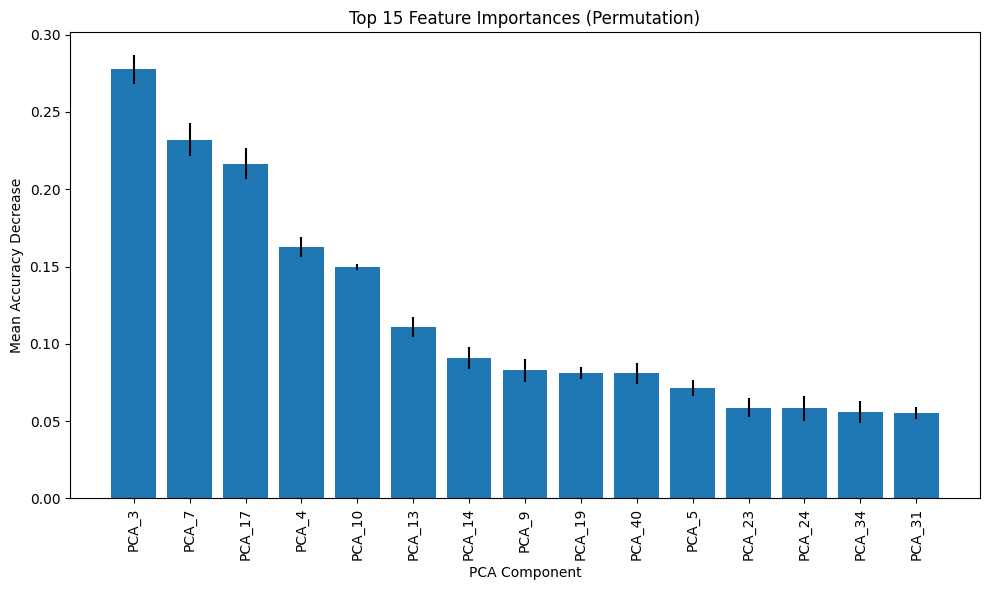

Permutation Importance analysis complete.


In [13]:
from tqdm.notebook import tqdm
import time

print("\n--- XAI: Permutation Importance ---")

# Apply PCA to reduce dimensionality for permutation importance
print("Applying PCA to reduce dimensionality for permutation importance...")
pca_for_perm = PCA(n_components=50)  # Reduce to 50 components like we did for SHAP
X_test_perm = pca_for_perm.fit_transform(X_test_final)

# Fit a new SVM on the PCA-transformed data
print("Training SVM on PCA-reduced features...")
svm_perm = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_perm.fit(pca_for_perm.transform(X_train_final), y_train_encoded)

# Calculate permutation importance on the reduced dataset with fewer repeats
n_repeats = 5  # Reduced from 10
print(f"Calculating Permutation Importance on {X_test_perm.shape[1]} PCA features with {n_repeats} repeats...")
print("This should be much faster than using all VGG16 features.")

# Set a max execution time
max_exec_time = 300  # 5 minutes max
start_time = time.time()

try:
    # Use a timeout mechanism
    perm_importance = permutation_importance(
        svm_perm,
        X_test_perm,
        y_test_encoded,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1  # Use all available CPU cores
    )
    
    # Report completion time
    elapsed_time = time.time() - start_time
    print(f"Permutation Importance calculation complete in {elapsed_time:.2f} seconds.")
    
    # Get feature importances
    importances_mean = perm_importance.importances_mean
    importances_std = perm_importance.importances_std
    
    # Get indices of top features
    num_top_features = min(15, len(importances_mean))
    top_indices = np.argsort(importances_mean)[::-1][:num_top_features]
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_top_features), importances_mean[top_indices], yerr=importances_std[top_indices], align='center')
    plt.xticks(range(num_top_features), [f'PCA_{i}' for i in top_indices], rotation=90)
    plt.xlabel('PCA Component')
    plt.ylabel('Mean Accuracy Decrease')
    plt.title(f'Top {num_top_features} Feature Importances (Permutation)')
    plt.tight_layout()
    plt.show()
    
    print("Permutation Importance analysis complete.")
    
except Exception as e:
    # If it still takes too long or encounters an error
    elapsed_time = time.time() - start_time
    print(f"Permutation importance calculation interrupted after {elapsed_time:.2f} seconds.")
    print(f"Error or timeout: {str(e)}")
    print("Skipping permutation importance analysis.")
    print("Alternative: Consider using the SHAP values we already calculated as a measure of feature importance.")